# A/B Testing for Spanish Translation
## Project Description
Our client Company X is a worldwide e-commerce site with localized versions of the site. One of our DS noticed that Spain-based users have a muhch higher conversion rate than any other Spanish-speaking country. She wanted to know what's the reason by talking with international team of Spain and LatAm. The manager suggested that one reason could be translation. All Spanish-speaking countries had the same translation of the site which was written by a Spainiard. They agreed to try a test where each country would have its one translation written by a local. That is, Argentinian users would see a translation written by an Argentinian, Mexican users by a Mexican and so on. Obviously, nothing would change for users from Spain.

After they run the test however, the test is negative, which means that non-localized translation was doing better!

We want to know:
* Confirm that the test is actually negative. That is, it appears that the old version of the site with just one translation across Spain and LatAm performs better
* Explain why that might be happening. Are the localized translations really worse?
* If you identified what was wrong, design an algorithm that would return FALSE if the same problem is happening in the future and TRUE if everything is good and te results can be trusted.

### Dataset Description
There are two table: 
* user_table: some information about the user, including their id, sex, age, country
* test_table: general information about the test results, including the user_id, date(whey they came to the site for the first time since the test started); source(marketing channel: Ads, SEO, Direct); device; browser_language(chosen by user); ads_channel(if user came from Ads, then the site where ads was displayed was recorded); browser; conversion(0,1); test(users are randomly splited into 1-test, 0-control, for Spanish-based users, this is 0 since there is no change)


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import datetime as dt
from datetime import datetime, date

### 1.Data Summary
#### 1.1 Test data

In [2]:
test_table = pd.read_csv("C:\\Users\\Tianyi Fang\\Desktop\\ken\\data_challenge\\AB_testing\\test_table.txt", sep = ',', header = 0)

In [4]:
print(test_table.info())
test_table.head()
#as description illustrated, there are some percentage of users came from ads

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 453321 entries, 0 to 453320
Data columns (total 9 columns):
user_id             453321 non-null int64
date                453321 non-null object
source              453321 non-null object
device              453321 non-null object
browser_language    453321 non-null object
ads_channel         181877 non-null object
browser             453321 non-null object
conversion          453321 non-null int64
test                453321 non-null int64
dtypes: int64(3), object(6)
memory usage: 20.8+ MB
None


,user_id,date,source,device,browser_language,ads_channel,browser,conversion,test
0,315281,2015-12-03,Direct,Web,ES,NaN,IE,1,0
1,497851,2015-12-04,Ads,Web,ES,Google,IE,0,1
2,848402,2015-12-04,Ads,Web,ES,Facebook,Chrome,0,0
3,290051,2015-12-03,Ads,Mobile,Other,Facebook,Android_App,0,1
4,548435,2015-11-30,Ads,Web,ES,Google,FireFox,0,1


In [25]:
test_table.ads_channel.count()

181877

In [35]:
# 1.How many observations? unique user?
print('There are %d observations and %d unique users in ABTesting data.'%(test_table.shape[0], len(test_table.user_id.unique())))
# 2.what is the testing period?
print('Test started from {0} and ends at {1}.'.format(test_table.date.min(), test_table.date.max()))
#the test ran for one week

There are 453321 observations and 453321 unique users in ABTesting data.
Test started from 2015-11-30 and ends at 2015-12-04.


In [56]:
# 3.how many values in source, device, browser_language, ads_channels and browsers?
def get_percent(df, var_list):
    for i in var_list:
        print('Value count percentage for {} in test_table'.format(i))
        print(df[i].value_counts()/(df[i].count()))
        print()
tool_info = ['source', 'device', 'browser_language', 'ads_channel', 'browser']
get_percent(test_table, tool_info)

Value count percentage for source in test_table
Ads       0.401210
SEO       0.398415
Direct    0.200375
Name: source, dtype: float64

Value count percentage for device in test_table
Web       0.554938
Mobile    0.445062
Name: device, dtype: float64

Value count percentage for browser_language in test_table
ES       0.832847
EN       0.139277
Other    0.027876
Name: browser_language, dtype: float64

Value count percentage for ads_channel in test_table
Facebook    0.376216
Google      0.374869
Yahoo       0.150844
Bing        0.075265
Other       0.022807
Name: ads_channel, dtype: float64

Value count percentage for browser in test_table
Android_App    0.342219
Chrome         0.224849
IE             0.136140
Iphone_App     0.102843
Safari         0.090587
FireFox        0.089927
Opera          0.013434
Name: browser, dtype: float64



In [40]:
# simply explore for conversion and test_split
get_percent(test_table, ['conversion', 'test'])

Value count percentage for conversion in test_table
0    0.950421
1    0.049579
Name: conversion, dtype: float64

Value count percentage for test in test_table
0    0.523554
1    0.476446
Name: test, dtype: float64



In [74]:
#maybe plot will give us better comparsion
def plot_dist(df, var):
    fig = plt.figure(figsize = (8,5))
    ax = fig.add_subplot(111)
    p = df[var].value_counts(dropna = True)
    psum = p.sum()
    p.plot(kind = 'bar', ax= ax)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize = 12)
    plt.xlabel(var, fontsize = 12)
    plt.ylabel('Count', fontsize = 12)
    plt.title('Distribution of ' + var) 
    for i,v in p.reset_index().iterrows():
        ax.text(i,v[var]+1, v[var],ha='left', va='bottom', fontsize = 12)
        ax.text(i,(v[var]/psum).round(3) + 1, (v[var]/psum).round(3),ha='center', va='top', fontsize = 14)

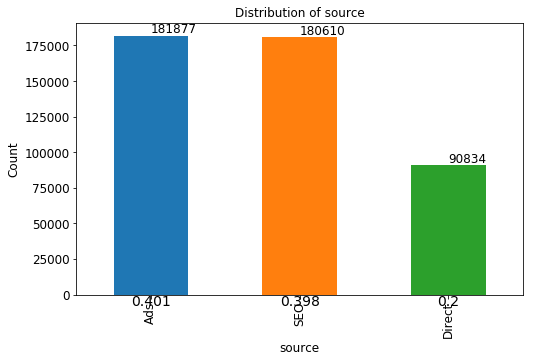

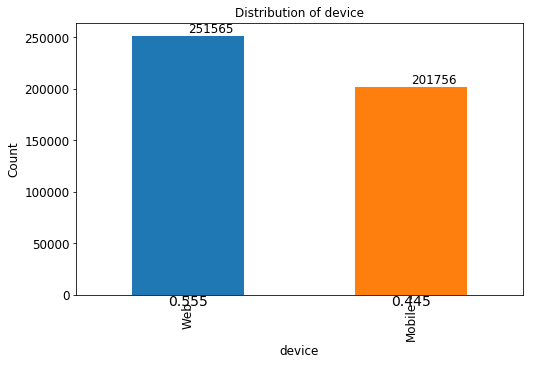

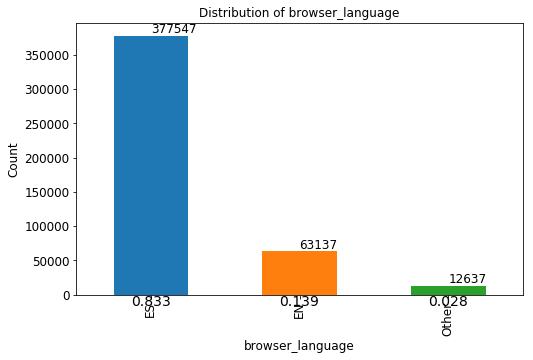

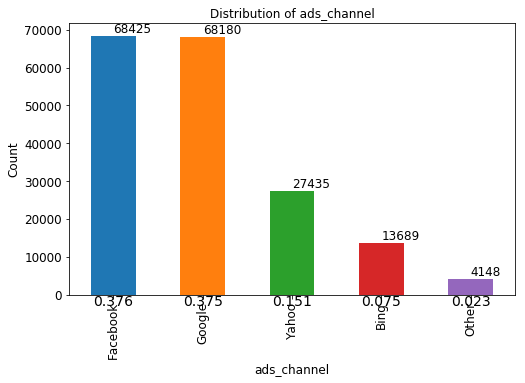

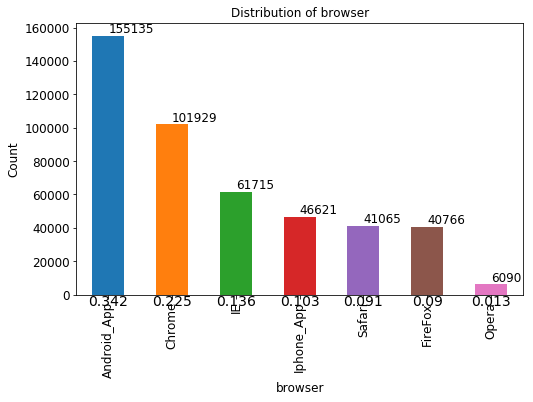

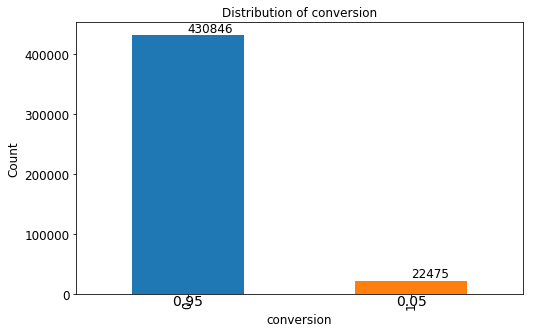

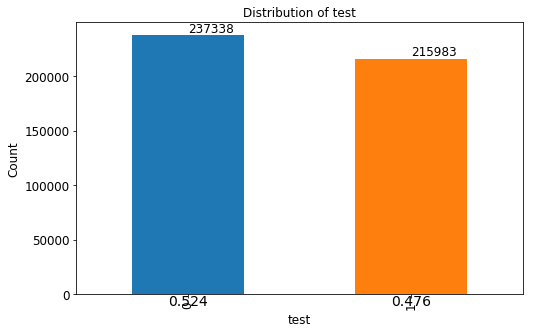

In [75]:
plot_dist(test_table,'source')
plot_dist(test_table,'device')
plot_dist(test_table,'browser_language')
plot_dist(test_table,'ads_channel')
plot_dist(test_table,'browser')
plot_dist(test_table,'conversion')
plot_dist(test_table,'test')

#### Summary of test_table:
* The result of AB test had 453321 records from 2015-11-30 to 2015-12-04, with 181877 users came from Ads channel. The rough conversion rate is nearly 5% for entire user pool.
#### 1.2. user data

In [3]:
user_table = pd.read_csv("C:\\Users\\Tianyi Fang\\Desktop\\ken\\data_challenge\\AB_testing\\user_table.txt", sep = ',', header = 0)
user_table.head()

,user_id,sex,age,country
0,765821,M,20,Mexico
1,343561,F,27,Nicaragua
2,118744,M,23,Colombia
3,987753,F,27,Venezuela
4,554597,F,20,Spain


In [43]:
# 1.How many observations? unique user?
print('There are %d observations and %d unique users in ABTesting user data.'%(user_table.shape[0], len(user_table.user_id.unique())))

There are 452867 observations and 452867 unique users in ABTesting user data.


In [77]:
# 2. How user's gender and country distributed?
get_percent(user_table, ['sex', 'country'])

# 3.How user age distributed?
user_table.age.describe()
#the smallest and largest seems normal

Value count percentage for sex in test_table
M    0.584024
F    0.415976
Name: sex, dtype: float64

Value count percentage for country in test_table
Mexico         0.283712
Colombia       0.119373
Spain          0.114343
Argentina      0.103194
Peru           0.074340
Venezuela      0.070780
Chile          0.043582
Ecuador        0.035099
Guatemala      0.033398
Bolivia        0.024564
Honduras       0.018919
El Salvador    0.018052
Paraguay       0.016223
Nicaragua      0.014845
Costa Rica     0.011723
Uruguay        0.009129
Panama         0.008724
Name: country, dtype: float64



count    452867.000000
mean         27.130740
std           6.776678
min          18.000000
25%          22.000000
50%          26.000000
75%          31.000000
max          70.000000
Name: age, dtype: float64

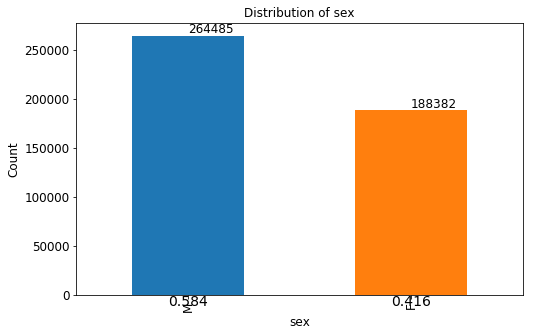

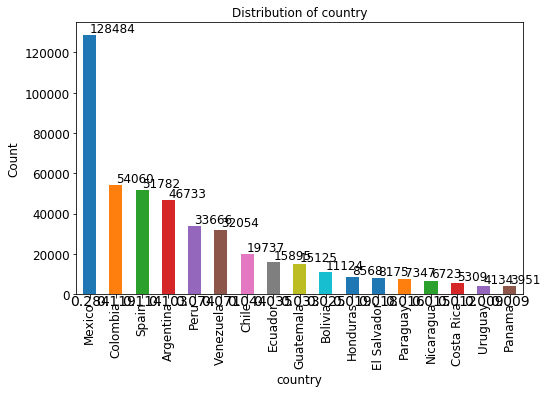

In [76]:
plot_dist(user_table,'sex')
plot_dist(user_table, 'country')

#### 1.3 Merge test and user table
Since we care about the user's location(country), we only explore records that has user information. 

After merge two dataset, we can explore deeper about how many user ourside Spain are treated as control group, and **confirm the AB Test result** about the correlation between variables, and the final conversion.  etc. 

In [4]:
test_user = pd.merge(test_table, user_table, on = ['user_id'], how = 'inner')
print(test_user.shape[0])
test_user.sample(8)

452867


,user_id,date,source,device,browser_language,ads_channel,browser,conversion,test,sex,age,country
293484,621843,2015-12-03,Ads,Mobile,ES,Facebook,Iphone_App,0,1,F,32,Mexico
189816,331928,2015-12-02,Direct,Web,ES,NaN,FireFox,0,0,M,27,Colombia
67231,812801,2015-12-01,SEO,Web,ES,NaN,Chrome,0,1,F,26,Uruguay
413090,844523,2015-11-30,Ads,Mobile,ES,Yahoo,Iphone_App,0,1,F,31,Argentina
350266,38207,2015-12-04,SEO,Mobile,ES,NaN,Android_App,0,0,M,24,El Salvador
384001,90684,2015-12-03,SEO,Mobile,ES,NaN,Android_App,0,1,M,22,Peru
432661,958585,2015-12-03,Direct,Web,ES,NaN,Opera,0,1,M,39,Venezuela
153876,995377,2015-12-04,SEO,Web,ES,NaN,IE,0,1,M,31,Bolivia


#### Before further explore, some cleaning job can be done.

In [5]:
test_user.date = pd.to_datetime(test_user.date)

In [6]:
test_user.test = test_user.test.replace({0:'control', 1:'test'})

In [7]:
test_user.to_csv("test_user.csv", index = False)

In [2]:
#reload in test_user for further work
test_user = pd.read_csv("C:\\Users\\Tianyi Fang\\Desktop\\ken\\data_challenge\\AB_testing\\test_user.csv", header = 0)

In [9]:
test_user.sample(8)

,user_id,date,source,device,browser_language,ads_channel,browser,conversion,test,sex,age,country
64561,641301,2015-12-04,Ads,Mobile,ES,Facebook,Android_App,0,test,F,36,El Salvador
322918,244825,2015-12-01,Direct,Web,ES,NaN,FireFox,0,control,M,29,Colombia
240323,323641,2015-11-30,SEO,Web,ES,NaN,IE,0,test,M,28,Mexico
357638,397164,2015-12-01,SEO,Web,ES,NaN,Safari,0,test,M,18,Mexico
374524,271784,2015-11-30,Direct,Mobile,EN,NaN,Android_App,0,test,M,33,Venezuela
340111,532316,2015-12-04,SEO,Web,ES,NaN,Safari,1,test,F,28,Colombia
128984,407596,2015-12-04,SEO,Web,ES,NaN,Safari,0,test,F,22,Argentina
75327,128238,2015-11-30,Direct,Mobile,ES,NaN,Android_App,0,control,M,19,Spain


### 2. Confirm A/B test result

In [83]:
def confirm_result(df, var):
    fig = plt.figure(figsize = (12,6))
    ax = fig.add_subplot(111)
    g = (df.groupby([var])['conversion'].value_counts()/(df.groupby([var])['conversion'].count()))
    gb = g.unstack()
    gb.plot(kind = 'bar', ax = ax, width = 0.9)
    plt.title('Distribution of ' + var + ' and Conversion rate', fontsize = 18)
    plt.xlabel(var, fontsize = 15)
    plt.xticks(rotation = 'vertical')
    plt.ylabel('conversion', fontsize = 15)
    plt.xticks(fontsize = 14)
    plt.yticks(fontsize = 14)
    plt.legend(title = 'conversion', loc='center left', bbox_to_anchor=(1, 0.5), fontsize = 13)
    for i,v in enumerate(g):
        ax.text(i/2.3-0.01,v, round(v, 3),ha='center', va='bottom', fontsize = 12)
    print('Conversion rate of entire ', var)
    print((df.groupby([var])['conversion'].value_counts()/df[var].count()).head())
    print('Conversion rate of each value in', var)
    print((df.groupby([var])['conversion'].value_counts()/(df.groupby([var])['conversion'].count())).head())

In [42]:
for i,v in enumerate(test_user.groupby('test')['conversion'].value_counts()):
    print(i)
    print(v)

0
224016
1
13077
2
206407
3
9367


Conversion rate of entire  test
test     conversion
control  0             0.494662
         1             0.028876
test     0             0.455778
         1             0.020684
Name: conversion, dtype: float64
Conversion rate of each value in test
test     conversion
control  0             0.944844
         1             0.055156
test     0             0.956589
         1             0.043411
Name: conversion, dtype: float64


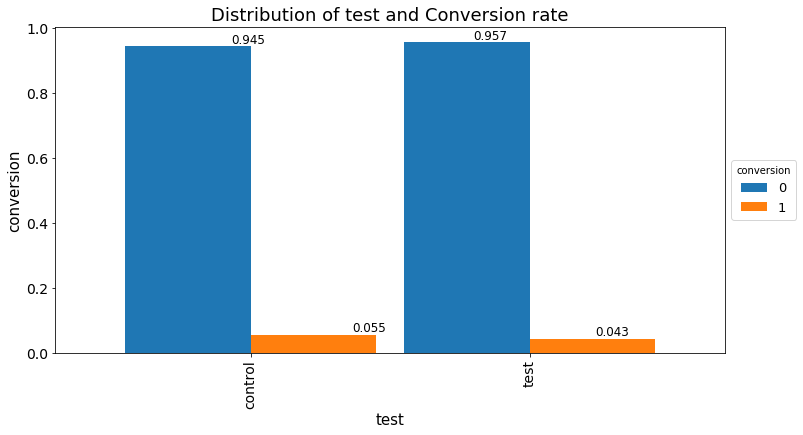

In [84]:
# 2.1 Conversion rate in control and test group
confirm_result(test_user, 'test')
#how much percentage are conversion in each group?


From the above plot, we find that although control group have more data, but the result shows the control group's conversion rate is 1.2% higher than the test group, which means the tested new version performs not as good as original version, which is unwilling to be seen by the company. Using T-test to vertify whether there is significant difference between two groups

#### T-test for conversion rate in control/test group

In [37]:
test_1 = test_user.conversion[test_user.test == 'test']
test_0 = test_user.conversion[test_user.test == 'control']

In [39]:
from scipy import stats
stats.ttest_ind(test_1, test_0, equal_var = False)

Ttest_indResult(statistic=-18.291393187719883, pvalue=1.0312099061277833e-74)

According to the result of T-test, p_value is close to 0, which means the difference between two group is significantly different from each other. 

### There might be something wrong with the experimental design:
#### 1. Enough data?
Required sample size to achieve a given power for a given effect size
Now we will move on to a more common scenario, where you have a design and effect size in mind and would like to know what sample size you would need to achieve a particular power (80% is typical). This is a straightforward extension of the previous example: we begin with a sample size and calculate the associated power. We then perform such a calculation repeatedly, each time increasing the sample size, until the power has reached the desired level.
Using power analysis to find out how many points we need in each group.

In [ ]:
import scipy.stats

country    conversion
Argentina  0             0.101750
           1             0.001444
Bolivia    0             0.023369
           1             0.001195
Chile      0             0.041416
Name: conversion, dtype: float64


country      conversion
Argentina    0             0.986006
             1             0.013994
Bolivia      0             0.951366
             1             0.048634
Chile        0             0.950296
             1             0.049704
Colombia     0             0.948668
             1             0.051332
Costa Rica   0             0.946506
             1             0.053494
Ecuador      0             0.950928
             1             0.049072
El Salvador  0             0.949235
             1             0.050765
Guatemala    0             0.950347
             1             0.049653
Honduras     0             0.950747
             1             0.049253
Mexico       0             0.949659
             1             0.050341
Nicaragua    0             0.946601
             1             0.053399
Panama       0             0.951911
             1             0.048089
Paraguay     0             0.951137
             1             0.048863
Peru         0             0.949742
    

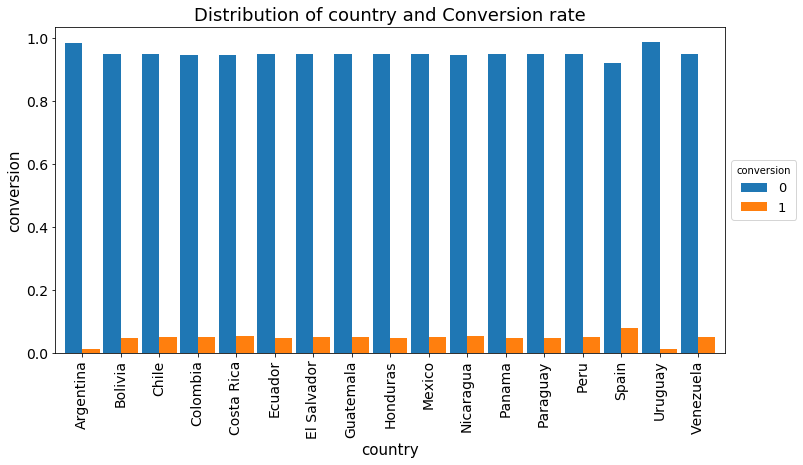

In [11]:
# 2.2 Conversion rate in different countries
confirm_result(test_user, 'country')
test_user.groupby('country')['conversion'].value_counts()/test_user.groupby('country')['conversion'].count()

Conversion rate of entire  sex
sex  conversion
F    0             0.395407
     1             0.020569
M    0             0.555033
     1             0.028991
Name: conversion, dtype: float64
Conversion rate of each value in sex
sex  conversion
F    0             0.950553
     1             0.049447
M    0             0.950360
     1             0.049640
Name: conversion, dtype: float64


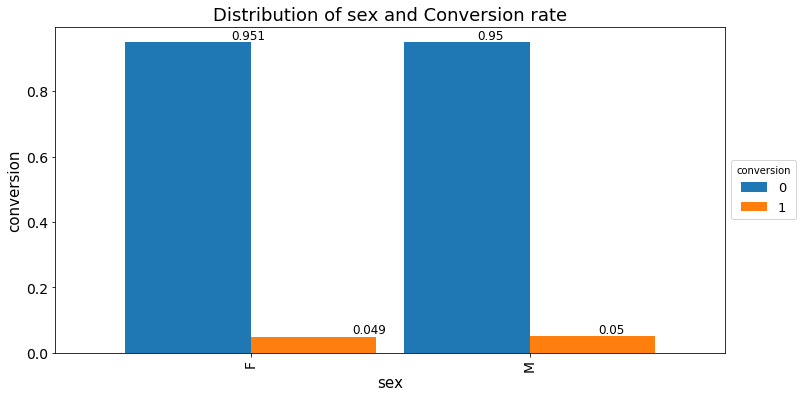

In [85]:
# 2.2 Conversion rate in different gender
confirm_result(test_user, 'sex')

age  conversion
18   0             0.054343
     1             0.002864
19   0             0.055988
     1             0.003001
20   0             0.056891
Name: conversion, dtype: float64


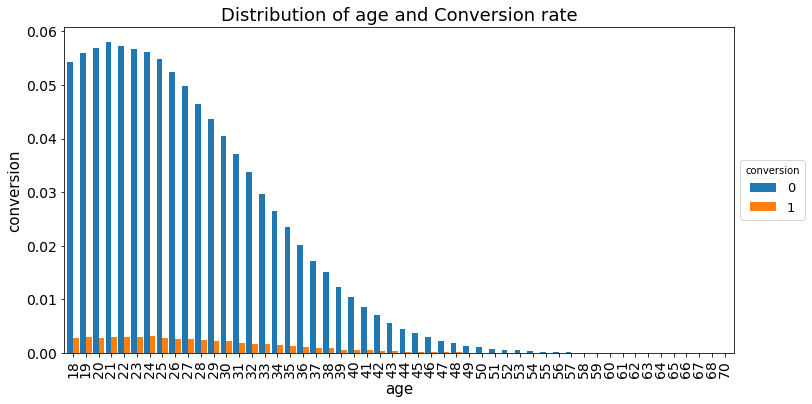

In [22]:
# 2.3 Conversion rate in different age
confirm_result(test_user, 'age')

Conversion rate of entire  date
date        conversion
2015-11-30  0             0.148695
            1             0.007969
2015-12-01  0             0.149112
            1             0.007479
2015-12-02  0             0.148055
Name: conversion, dtype: float64
Conversion rate of each value in date
date        conversion
2015-11-30  0             0.949132
            1             0.050868
2015-12-01  0             0.952239
            1             0.047761
2015-12-02  0             0.949958
Name: conversion, dtype: float64


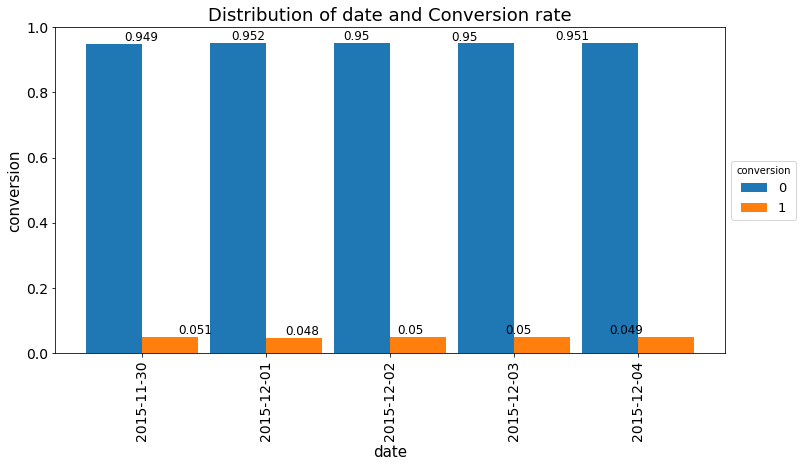

In [86]:
# 2.4 Conversion rate in different
confirm_result(test_user, 'date')